In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Reshape, Flatten, UpSampling2D, Conv2D, MaxPooling2D, Dropout

In [2]:
def visualize_images(img, num_images=5):
    total_images = len(img)
    num_rows = int(np.ceil(total_images / num_images))  # 필요한 행의 수 계산
    
    # 서브플롯 생성 (num_rows 행과 num_images 열)
    fig, axes = plt.subplots(num_rows, num_images, figsize=(num_images * 3, num_rows * 3))
    
    # 만약 num_rows가 1이라면, axes를 1차원 배열로 처리하도록 설정
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # 이미지 그리기
    for i in range(total_images):
        row = i // num_images  # 현재 행
        col = i % num_images  # 현재 열
        axes[row, col].imshow(img[i].squeeze(), cmap='gray')  # 이미지 표시
        axes[row, col].set_title(f"Image {i+1}")  # 이미지 제목 설정
        axes[row, col].axis('off')  # 축 숨기기
    
    # 남은 빈 서브플롯 숨기기
    for i in range(total_images, num_rows * num_images):
        row = i // num_images
        col = i % num_images
        axes[row, col].axis('off')  # 빈 칸은 숨기기
    
    plt.tight_layout()
    plt.show()

In [3]:
df_fdc = pd.read_excel('./data/raw/Sensor_Data_DSS_반출.xlsx')

동일값으로만 이루어진 열 확인

In [4]:
def find_constant_columns(df):
    constant_columns = {}
    for col in df.columns:
        if df[col].nunique() == 1:  
            constant_columns[col] = df[col].iloc[0] 
    return constant_columns

constant_columns = find_constant_columns(df_fdc)
print("같은 값으로 이루어진 열과 값:", constant_columns)

같은 값으로 이루어진 열과 값: {}


결측치 확인

In [5]:
def count_all_nan_rows(df):
    nan_rows_count = df.iloc[:, 5:].isna().all(axis=1).sum()
    print(f"모든 값이 NaN인 행의 개수: {nan_rows_count}")

count_all_nan_rows(df_fdc)

모든 값이 NaN인 행의 개수: 243


In [6]:
def remove_all_nan_rows(df):
    nan_rows = df.iloc[:, 5:].isna().all(axis=1)
    df_cleaned = df[~nan_rows]
    return df_cleaned

df_fdc_remove_missing = remove_all_nan_rows(df_fdc)
print(f'{df_fdc.shape} → {df_fdc_remove_missing.shape}')

(1309, 276) → (1066, 276)


In [7]:
count_all_nan_rows(df_fdc_remove_missing)

모든 값이 NaN인 행의 개수: 0


In [8]:
def get_columns_with_missing_values(df):
    missing_values = df.isnull().sum()  
    missing_columns = missing_values[missing_values > 0]
    return missing_columns

missing_columns = get_columns_with_missing_values(df_fdc_remove_missing)

In [9]:
def remove_columns_with_missing_values(df, missing_columns):
    df_cleaned = df.drop(columns=missing_columns.index)
    return df_cleaned

df_fdc_cleaned = remove_columns_with_missing_values(df_fdc_remove_missing, missing_columns)

In [10]:
no_image_list = ['ID_1231', 'ID_1233', 'ID_1239', 'ID_1241', 'ID_1244', 'ID_1245','ID_1309']
df_final = df_fdc_cleaned[~df_fdc_cleaned['ID'].isin(no_image_list)]

정규화

In [11]:
scaler =StandardScaler()

sensor_data = df_final.iloc[:,5:]
sensor_data_scaled = scaler.fit_transform(sensor_data)
df_sensor_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)
df_fdc_scaled = pd.concat([df_final.iloc[:,:5].reset_index(drop=True), df_sensor_scaled.reset_index(drop=True)], axis=1)

라벨 추출

In [12]:
labels = df_fdc_scaled['PASS(1)/FAIL(0)'].values
labels = np.array(labels)

이미지 데이터 추출 및 배열 변환

In [13]:
def get_image_filenames(image_folder, image_ids):
    image_filenames = []
    for image_id in image_ids:
        image_path = os.path.join(image_folder, f"{image_id}.png")
        if os.path.exists(image_path): 
            image_filenames.append(image_path) 
        else:
            print(f"파일을 찾을 수 없습니다: {image_id}")
    return image_filenames

image_folder = './data/image'
image_ids = df_final['ID']
image_filenames = get_image_filenames(image_folder, image_ids)

In [14]:
def compare_image_order():
    image_ids = [os.path.basename(filename).split('.')[0] for filename in image_filenames]
    comparison_result = df_final['ID'].astype(str) == image_ids

    if comparison_result.all():
        print("image_filenames의 순서와 df_final['ID']의 순서가 모두 일치합니다.")
    else:
        print("일치하지 않는 항목이 있습니다.")
        mismatch_indices = comparison_result[comparison_result == False].index
        print(f"일치하지 않는 인덱스: {mismatch_indices.tolist()}")

compare_image_order()

image_filenames의 순서와 df_final['ID']의 순서가 모두 일치합니다.


In [15]:
def image_to_numpy(file_path):
    image = Image.open(file_path).convert('L')  # Convert image to grayscale
    image = image.resize((128, 128))
    return np.array(image) / 255.0

image_data = np.array([image_to_numpy(file) for file in image_filenames])

모델

1. FDC data → Image 예측

2. Image → Scratch 분류

Train / Validation / Test

In [16]:
fdc_train, fdc_temp, img_train, img_temp, labels_train, labels_temp = train_test_split(
    df_sensor_scaled, image_data, labels, test_size=0.2, random_state=42
)

fdc_val, fdc_test, img_val, img_test, labels_val, labels_test = train_test_split(
    fdc_temp, img_temp, labels_temp, test_size=0.25, random_state=42  # 0.25 of the remaining 20% = 5% of total
)

FDC data → Image 예측 모델

1. GAN

In [17]:
# # Generator 모델: FDC 데이터를 입력으로 받아 128x128 이미지 생성
# def build_generator(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(128 * 128, activation='tanh'))
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Discriminator 모델: 128x128 이미지를 입력으로 받아 불량/정상을 판별
# def build_discriminator(img_shape):
#     model = tf.keras.Sequential()
    
#     model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1, activation='sigmoid'))
    
#     return model

# # 모델 컴파일
# def compile_gan(generator, discriminator):
#     # 생성기와 판별기를 연결하는 GAN 모델
#     discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
#     discriminator.trainable = False

#     # GAN 모델은 생성기와 판별기를 결합하여 학습합니다
#     gan_input = layers.Input(shape=(fdc_train.shape[1],))
#     generated_img = generator(gan_input)
    
#     gan_output = discriminator(generated_img)
#     gan_model = tf.keras.Model(gan_input, gan_output)
#     gan_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    
#     return gan_model

# # 하이퍼파라미터
# epochs = 100
# batch_size = 32
# input_dim = fdc_train.shape[1]
# img_shape = (128, 128, 1)

# # 모델 빌드
# generator = build_generator(input_dim)
# discriminator = build_discriminator(img_shape)
# gan_model = compile_gan(generator, discriminator)

# # 학습 함수
# def train_gan(epochs, batch_size):
#     for epoch in range(epochs):
#         # 1. Real Image를 Discriminator에 제공하여 학습
#         idx = np.random.randint(0, img_train.shape[0], batch_size)
#         real_imgs = img_train[idx]
#         real_labels = np.ones((batch_size, 1))

#         # 2. Generator가 생성한 가짜 이미지를 Discriminator에 제공하여 학습
#         noise = np.random.normal(0, 1, (batch_size, input_dim))
#         fake_imgs = generator.predict(noise)
#         fake_labels = np.zeros((batch_size, 1))

#         # Discriminator 학습
#         d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
#         d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
#         d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#         # Generator 학습
#         g_loss = gan_model.train_on_batch(noise, real_labels)

#         # 100 에포크마다 학습 상태 출력
#         if epoch % 100 == 0:
#             print(f"{epoch}/{epochs} [D loss: {d_loss[0]}, acc: {100*d_loss[1]:.2f}] [G loss: {g_loss}]")

# # GAN 학습 시작
# train_gan(epochs, batch_size)

# # 이미지 예측
# predicted_images = generator.predict(fdc_test)

# # 불량/정상 분류 (Scratch 여부 판정)
# predicted_class = discriminator.predict(predicted_images)

2. AutoEncoder

In [18]:
# # Encoder 모델: 입력 이미지를 잠재 공간으로 압축
# def build_encoder(input_dim):
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(256, input_dim=input_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(1024))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     # 잠재 공간 (저차원 공간) 출력
#     model.add(layers.Dense(64))  # 잠재 공간의 크기를 64로 설정
    
#     return model

# # Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_decoder(latent_dim):
#     model = tf.keras.Sequential()
    
#     model.add(layers.Dense(1024, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.BatchNormalization(momentum=0.8))
    
#     model.add(layers.Dense(512))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     model.add(layers.Dense(256))
#     model.add(layers.LeakyReLU(alpha=0.2))
    
#     # 128x128 이미지로 복원
#     model.add(layers.Dense(128 * 128, activation='sigmoid'))  # 이미지 픽셀 값이 0-1 범위이므로 sigmoid 사용
#     model.add(layers.Reshape((128, 128, 1)))
    
#     return model

# # Autoencoder 모델: Encoder와 Decoder를 연결
# def build_autoencoder(input_dim, latent_dim):
#     encoder = build_encoder(input_dim)
#     decoder = build_decoder(latent_dim)
    
#     inputs = layers.Input(shape=(input_dim,))
#     encoded = encoder(inputs)
#     decoded = decoder(encoded)
    
#     autoencoder = tf.keras.Model(inputs, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
#     return autoencoder

# # 하이퍼파라미터
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 300
# batch_size = 32

# # 모델 빌드
# autoencoder = build_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 이미지 예측
# predicted_images = autoencoder.predict(fdc_test)

2-1. CAE(Convolution AutoEncoder)

In [19]:
import tensorflow as tf
from tensorflow.keras import layers

# Encoder 모델: 입력 이미지를 잠재 공간으로 압축 (Convolutional Layer 사용)
def build_conv_encoder(input_shape):
    model = tf.keras.Sequential()

    # Conv -> LeakyReLU -> BatchNorm
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    # 잠재 공간 (Latent space)으로 변환
    model.add(layers.Flatten())
    model.add(layers.Dense(64))  # 잠재 공간의 크기 64로 설정

    return model

# Decoder 모델: 잠재 공간에서 128x128 이미지를 복원 (Transpose Convolution 사용)
def build_conv_decoder(latent_dim):
    model = tf.keras.Sequential()

    # Dense -> LeakyReLU -> Reshape
    model.add(layers.Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((16, 16, 128)))  # Decoder가 16x16 이미지에서 시작

    # ConvTranspose -> LeakyReLU -> BatchNorm
    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # 128x128 이미지로 복원
    model.add(layers.Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid'))

    return model

# CAE 모델: Encoder와 Decoder를 연결
def build_autoencoder(input_shape, latent_dim):
    encoder = build_conv_encoder(input_shape)
    decoder = build_conv_decoder(latent_dim)
    
    inputs = layers.Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = tf.keras.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
    return autoencoder

# 하이퍼파라미터
input_shape = (128, 128, 1)  # 이미지 데이터의 차원 (흑백 이미지이므로 채널 수 1)
latent_dim = 64  # 잠재 공간의 크기
epochs = 300
batch_size = 32

# 모델 빌드
autoencoder = build_autoencoder(input_shape, latent_dim)

# 학습 함수
def train_autoencoder(epochs, batch_size):
    autoencoder.fit(img_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(img_val, img_val))

# Autoencoder 학습 시작
train_autoencoder(epochs, batch_size)

# 이미지 예측
predicted_images = autoencoder.predict(img_test)


c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\rkdeo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 629ms/step - loss: 0.1222 - val_loss: 0.0044
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 649ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 602ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 601ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 597ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 580ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 577ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 572ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 594ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 583ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/300
27/27 ━━━━━━━━━━━

3. Diffusion

In [20]:
# import numpy as np
# import cv2
# import tensorflow as tf
# from tensorflow.keras import layers

# # Noise scheduler (beta와 alpha 값들 생성)
# def create_beta_schedule(T, start=0.0001, end=0.02):
#     return np.linspace(start, end, T)

# # Forward process: 점진적으로 노이즈를 추가
# def forward_diffusion_process(x_0, t, beta_schedule):
#     noise = np.random.normal(size=x_0.shape)
#     alpha_t = np.prod(1 - beta_schedule[:t+1])
#     noisy_image = np.sqrt(alpha_t) * x_0 + np.sqrt(1 - alpha_t) * noise
#     return noisy_image

# # 네트워크: U-Net과 유사한 구조로 reverse process를 학습
# def build_diffusion_model(input_shape):
#     inputs = layers.Input(shape=input_shape)
    
#     # Down-sampling layers (convolutional layers)
#     x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     # Bottleneck
#     x = layers.Conv2D(256, kernel_size=3, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
    
#     # Up-sampling layers (deconvolutional layers)
#     x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization()(x)
    
#     # Output layer: 노이즈 제거된 이미지
#     outputs = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)
    
#     model = tf.keras.Model(inputs, outputs)
#     return model

# # 모델 빌드
# input_shape = (128, 128, 1)  # 이미지 크기
# diffusion_model = build_diffusion_model(input_shape)

# # 모델 컴파일
# diffusion_model.compile(optimizer='adam', loss='mse')

# # 하이퍼파라미터
# epochs = 100
# batch_size = 32
# T = 1000  # Total diffusion steps
# beta_schedule = create_beta_schedule(T)  # beta 일정 생성

# # 1차원 데이터를 2차원 이미지로 변환하는 함수 (예: 128x128 크기 이미지로 변환)
# def reshape_fdc_to_image(fdc_data, target_shape=(128, 128)):
#     reshaped_images = []
#     for i in range(fdc_data.shape[0]):
#         # 1차원 데이터를 target_shape로 변환 (128x128으로 변환)
#         reshaped_img = np.resize(fdc_data[i], target_shape)
#         reshaped_images.append(reshaped_img)
    
#     # (batch_size, 128, 128, 1)로 변환 (이미지 채널 추가)
#     reshaped_images = np.expand_dims(np.array(reshaped_images), axis=-1)
#     return reshaped_images

# # Forward diffusion process를 위한 학습 함수
# def train_diffusion_model(epochs, batch_size, fdc_train, img_train):
#     for epoch in range(epochs):
#         # 각 배치마다 데이터를 섞어서 사용
#         idx = np.random.randint(0, fdc_train.shape[0], batch_size)
#         real_imgs = img_train[idx]
        
#         # T 스텝 중에서 랜덤하게 t 선택
#         t = np.random.randint(0, T)
        
#         # Forward diffusion process (노이즈 추가)
#         noisy_imgs = forward_diffusion_process(real_imgs, t, beta_schedule)
        
#         # Reverse process 학습 (noisy_imgs에서 원래 이미지로 복원)
#         loss = diffusion_model.train_on_batch(noisy_imgs, real_imgs)
        
#         # 에포크마다 출력
#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}/{epochs}, Loss: {loss}")

# # 모델 학습 시작 (fdc_train과 img_train은 사전에 정의된 데이터셋이어야 함)
# # train_diffusion_model(epochs, batch_size, fdc_train, img_train)

# # 이미지 전처리 함수: 이미지 크기를 (128, 128, 1)로 변환
# def preprocess_image(image):
#     # 이미지가 (128, 128)인지 확인하고 변환
#     if image.shape != (128, 128):
#         image = cv2.resize(image, (128, 128))
    
#     # 이미지를 (128, 128, 1)로 reshape (차원을 추가)
#     image = np.expand_dims(image, axis=-1)
    
#     return image

# # 이미지 예측 함수
# def predict_images(fdc_test):
#     # fdc_test를 이미지 형태로 변환 (128x128 크기의 이미지)
#     reshaped_images = reshape_fdc_to_image(fdc_test, target_shape=(128, 128))
    
#     # 모델에 예측을 적용 (reverse diffusion process 진행)
#     for t in reversed(range(T)):
#         reshaped_images = diffusion_model.predict(reshaped_images)
    
#     return reshaped_images

# # 2차원 이미지를 다시 1차원 데이터로 변환하는 함수
# def reshape_image_to_fdc(image_data):
#     reshaped_fdc_data = []
#     for img in image_data:
#         reshaped_fdc_data.append(img.flatten())  # 이미지 데이터를 1차원으로 변환
    
#     return np.array(reshaped_fdc_data)

# # 예측 실행
# # 예시 fdc_test: (53, 216)의 1차원 데이터 (샘플 데이터)
# fdc_test = np.random.rand(53, 216)  # 53개의 216차원 데이터 샘플 (예시)

# # 예측 실행
# predicted_images = predict_images(fdc_test)

# # 예측된 이미지를 다시 1차원 데이터로 변환
# predicted_fdc_data = reshape_image_to_fdc(predicted_images)

# # 출력 결과 확인
# print("예측된 1차원 데이터 형태:", predicted_fdc_data.shape)


4. Transformer

In [21]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Transformer Encoder 모델: FDC 데이터를 잠재 공간으로 압축
# def build_transformer_encoder(input_dim, latent_dim, num_heads=8, ff_dim=512):
#     fdc_input = layers.Input(shape=(input_dim,))
    
#     # FDC 데이터를 Linear로 매핑하고 패치로 변환
#     x = layers.Dense(ff_dim, activation='relu')(fdc_input)
#     x = layers.Reshape((16, 32))(x)  # 데이터를 패치로 나눔 (예시: 16개의 패치)
    
#     # Multi-Head Attention
#     transformer_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=32)
#     x = transformer_layer(x, x)
    
#     # FFN (Feed Forward Network)
#     x = layers.Dense(ff_dim, activation='relu')(x)
#     x = layers.Flatten()(x)

#     # 잠재 공간으로 매핑
#     latent_vector = layers.Dense(latent_dim)(x)
    
#     return models.Model(fdc_input, latent_vector)

# # Transformer Decoder 모델: 잠재 공간에서 128x128 이미지를 복원
# def build_transformer_decoder(latent_dim):
#     latent_input = layers.Input(shape=(latent_dim,))
    
#     # Latent vector를 dense layer로 매핑하여 이미지 복원
#     x = layers.Dense(1024)(latent_input)
#     x = layers.LeakyReLU(alpha=0.2)(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)
    
#     x = layers.Dense(512)(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
    
#     x = layers.Dense(256)(x)
#     x = layers.LeakyReLU(alpha=0.2)(x)
    
#     # 128x128 이미지로 복원
#     x = layers.Dense(128 * 128, activation='sigmoid')(x)  # 이미지 픽셀 값이 0-1 범위이므로 sigmoid 사용
#     img_output = layers.Reshape((128, 128, 1))(x)  # 128x128 이미지로 재구성
    
#     return models.Model(latent_input, img_output)

# # Transformer Autoencoder 모델: Encoder와 Decoder를 연결
# def build_transformer_autoencoder(input_dim, latent_dim):
#     encoder = build_transformer_encoder(input_dim, latent_dim)
#     decoder = build_transformer_decoder(latent_dim)
    
#     # 입력 FDC 데이터를 받아 잠재 벡터 생성 후 이미지를 예측
#     fdc_input = layers.Input(shape=(input_dim,))
    
#     # Encoder에서 잠재 공간 벡터 생성
#     latent_vector = encoder(fdc_input)
    
#     # Decoder에서 잠재 공간 벡터를 사용하여 이미지를 복원
#     decoded_img = decoder(latent_vector)
    
#     # 모델 정의
#     autoencoder = tf.keras.Model(fdc_input, decoded_img)
#     autoencoder.compile(optimizer='adam', loss='mse')  # Autoencoder에서는 MSE(평균 제곱 오차)를 사용
#     return autoencoder

# # 하이퍼파라미터
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 64  # 잠재 공간의 크기
# epochs = 10
# batch_size = 32

# # Transformer Autoencoder 모델 빌드
# autoencoder = build_transformer_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(fdc_val, img_val))

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 이미지 예측
# predicted_images = autoencoder.predict(fdc_test)



5. CNN기반 회귀모델

In [22]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# # CNN Encoder: FDC 데이터를 이미지 공간으로 매핑
# def build_cnn_encoder(input_dim):
#     fdc_input = layers.Input(shape=(input_dim,))
    
#     # 입력 데이터를 1차원에서 2차원으로 변환
#     x = layers.Dense(1024, activation='relu')(fdc_input)
#     x = layers.Reshape((32, 32, 1))(x)  # 32x32 크기로 매핑
    
#     # CNN 레이어
#     x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
    
#     x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
    
#     # Fully Connected 레이어
#     x = layers.Flatten()(x)
#     latent_vector = layers.Dense(512, activation='relu')(x)
    
#     return models.Model(fdc_input, latent_vector)

# # CNN Decoder: 잠재 벡터를 128x128 이미지로 복원
# def build_cnn_decoder(latent_dim):
#     latent_input = layers.Input(shape=(latent_dim,))
    
#     # Latent vector를 이미지로 복원
#     x = layers.Dense(32 * 32 * 64, activation='relu')(latent_input)
#     x = layers.Reshape((32, 32, 64))(x)
    
#     # CNN 디코딩 레이어
#     x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
#     x = layers.UpSampling2D((2, 2))(x)
    
#     x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
#     x = layers.UpSampling2D((2, 2))(x)
    
#     # 최종적으로 128x128 이미지로 복원
#     img_output = layers.Conv2DTranspose(1, (3, 3), activation='linear', padding='same')(x)
    
#     return models.Model(latent_input, img_output)

# # CNN 기반 Autoencoder 모델: Encoder와 Decoder를 연결
# def build_cnn_autoencoder(input_dim, latent_dim):
#     encoder = build_cnn_encoder(input_dim)
#     decoder = build_cnn_decoder(latent_dim)
    
#     # 입력 FDC 데이터를 받아 잠재 벡터 생성 후 이미지를 예측
#     fdc_input = layers.Input(shape=(input_dim,))
    
#     # Encoder에서 잠재 공간 벡터 생성
#     latent_vector = encoder(fdc_input)
    
#     # Decoder에서 잠재 공간 벡터를 사용하여 이미지를 복원
#     decoded_img = decoder(latent_vector)
    
#     # 모델 정의
#     autoencoder = tf.keras.Model(fdc_input, decoded_img)
#     autoencoder.compile(optimizer='adam', loss='mse')  # 회귀 문제이므로 MSE 사용
#     return autoencoder

# # 하이퍼파라미터
# input_dim = fdc_train.shape[1]  # FDC 데이터의 차원
# latent_dim = 512  # 잠재 공간의 크기
# epochs = 10
# batch_size = 32

# # CNN Autoencoder 모델 빌드
# autoencoder = build_cnn_autoencoder(input_dim, latent_dim)

# # 학습 함수
# def train_autoencoder(epochs, batch_size):
#     autoencoder.fit(fdc_train, img_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(fdc_val, img_val))

# # Autoencoder 학습 시작
# train_autoencoder(epochs, batch_size)

# # 이미지 예측
# predicted_images = autoencoder.predict(fdc_test)


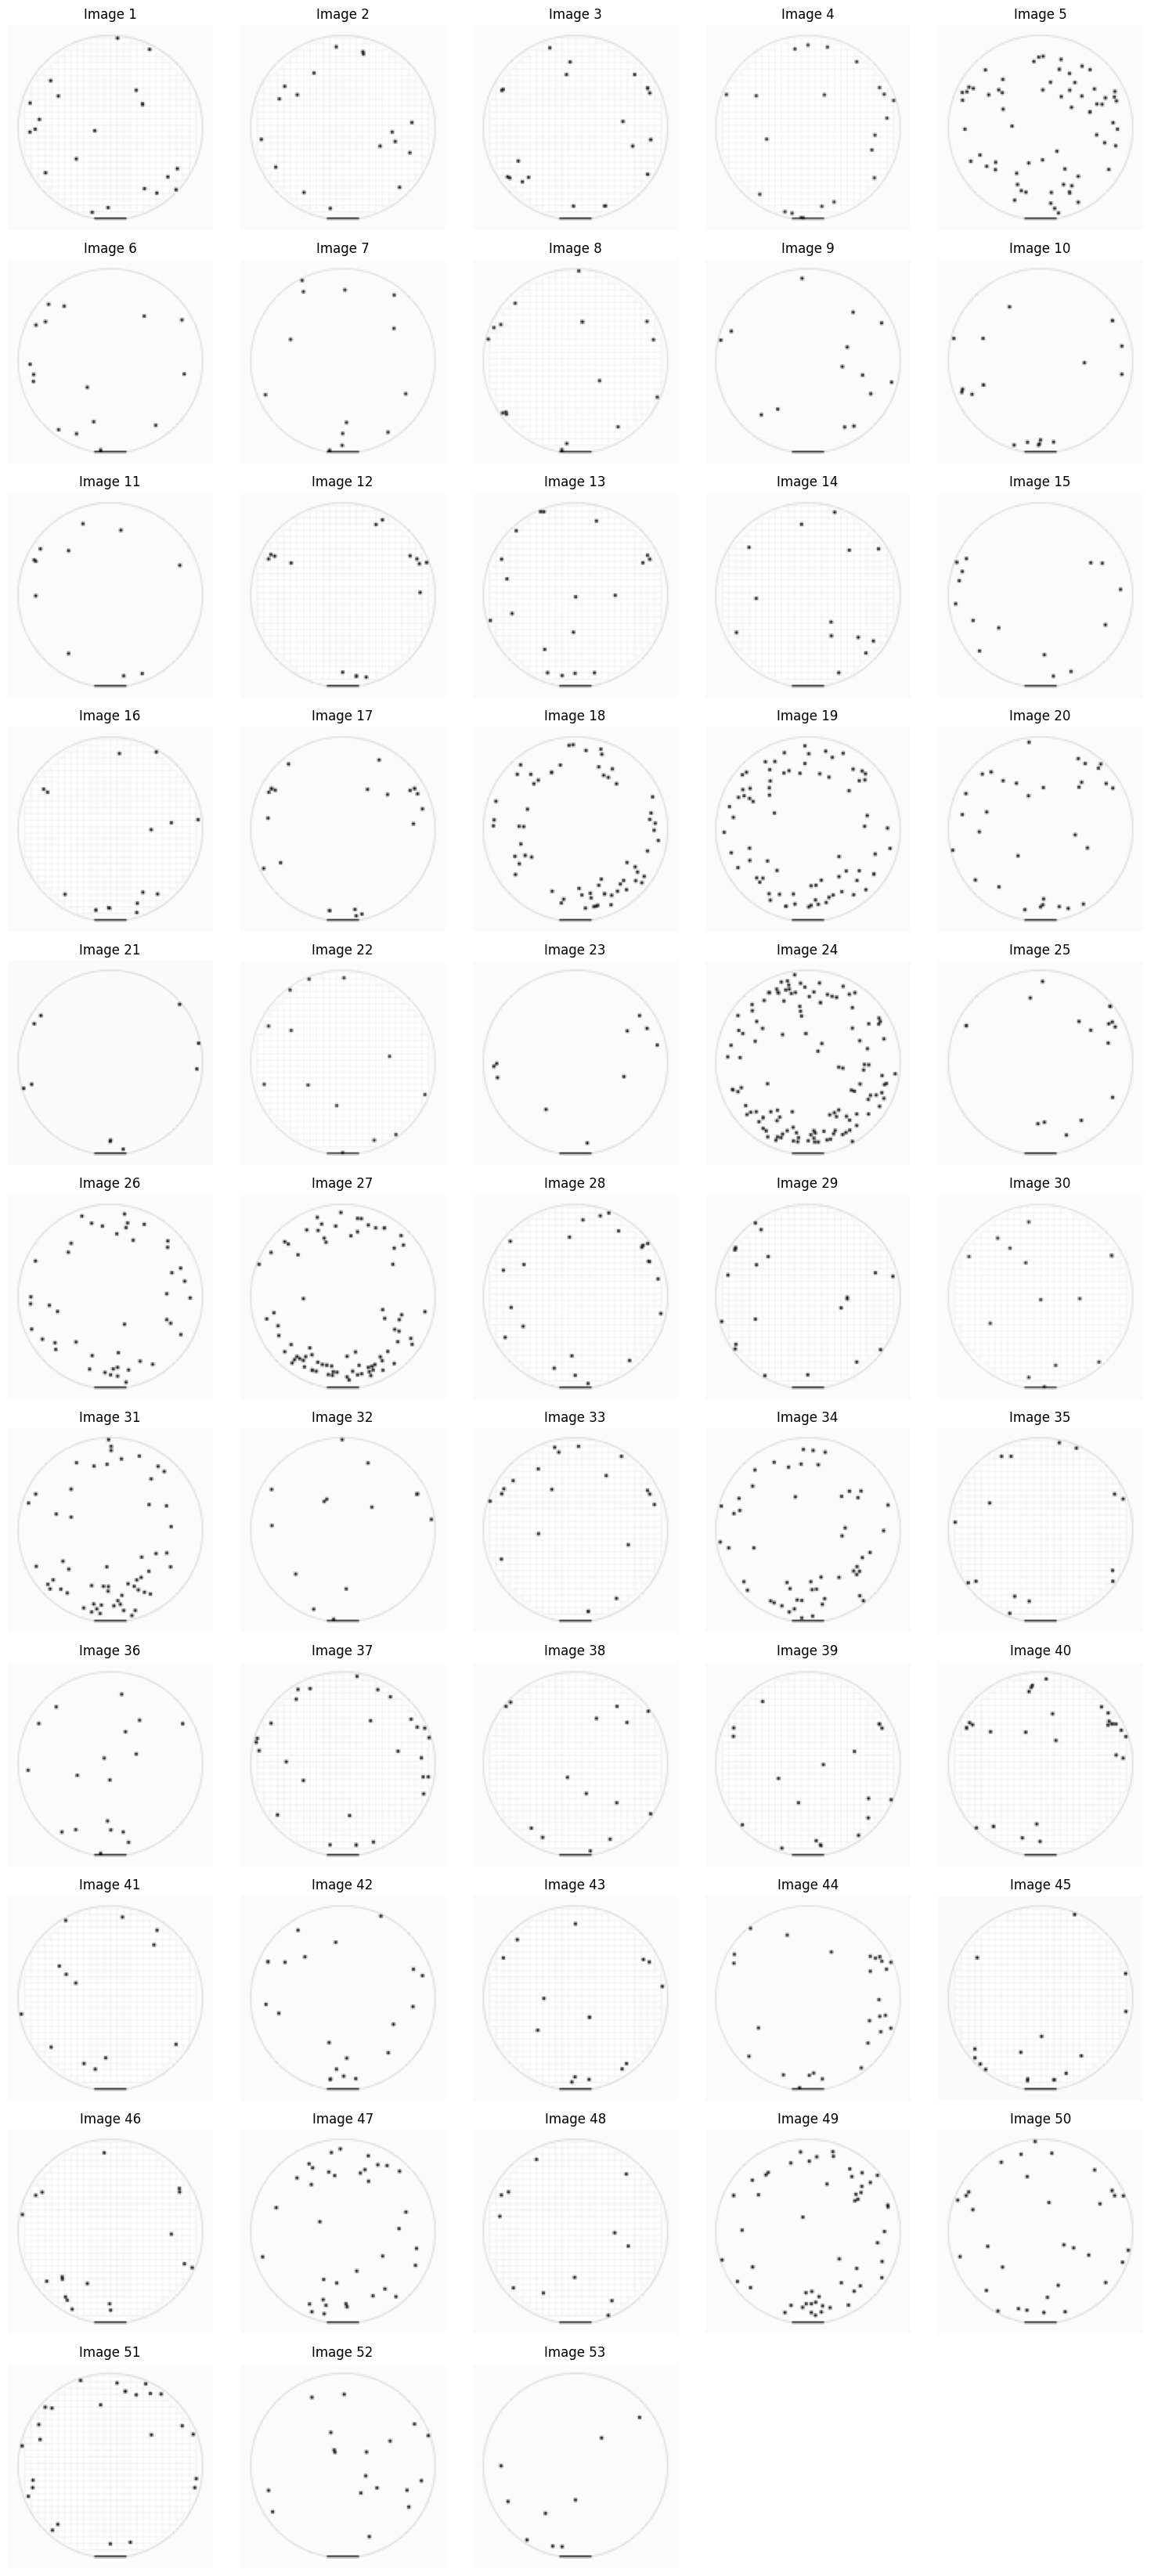

In [23]:
visualize_images(img_test)

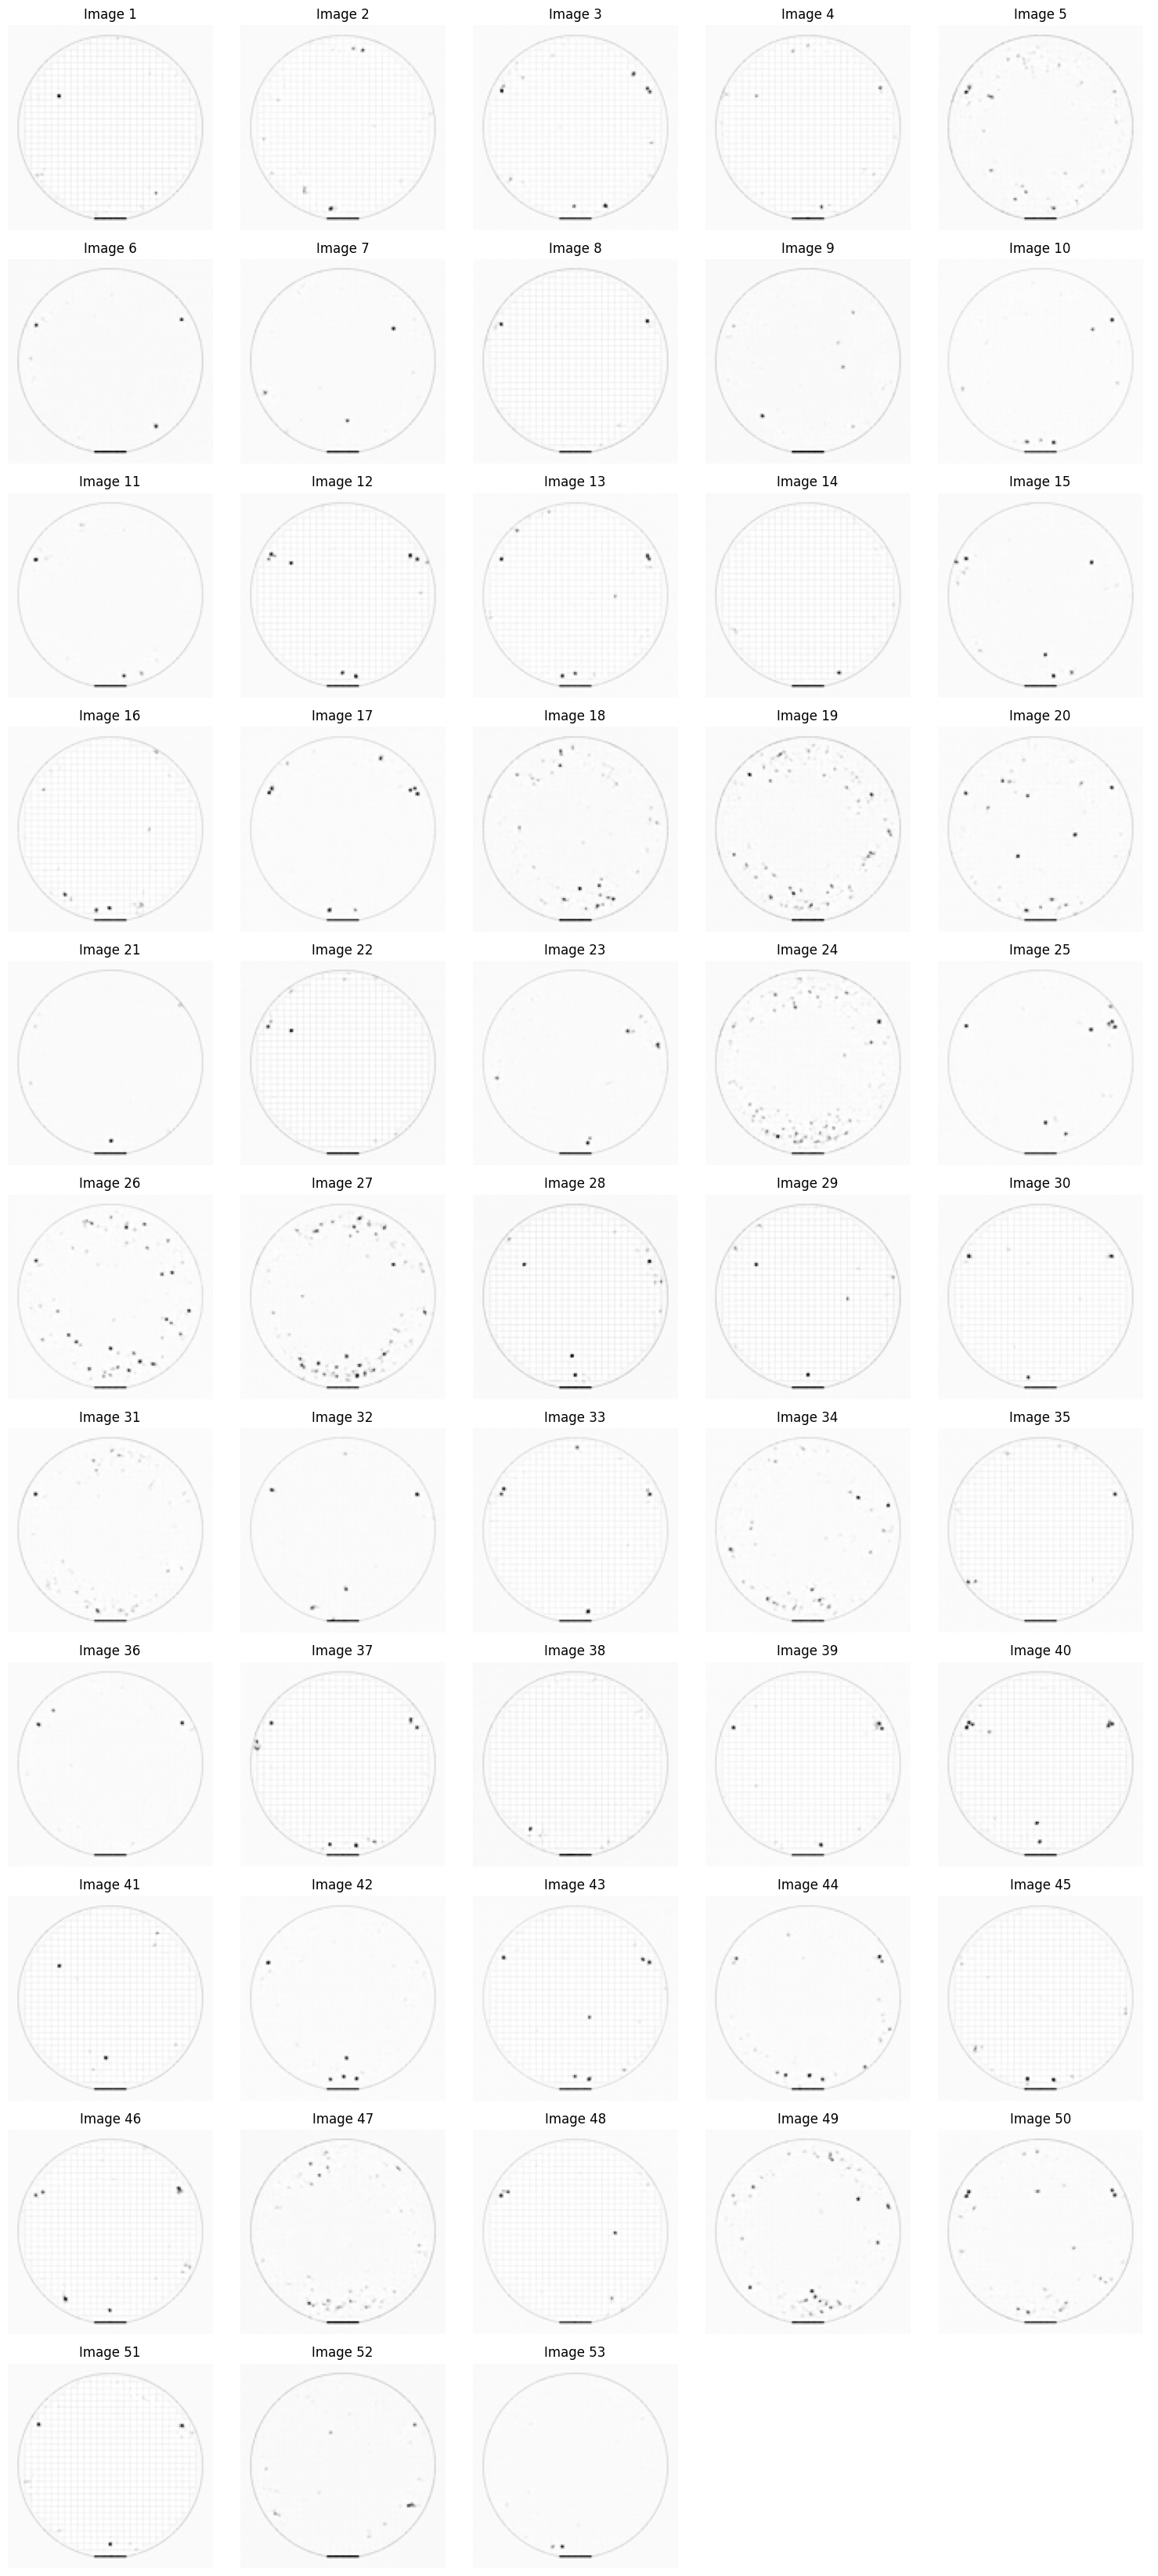

In [24]:
visualize_images(predicted_images)

Image → Scratch 분류 모델

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN 모델 정의
def build_classification_model(input_shape):
    model = Sequential()

    # 컨볼루션 레이어
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    # 완전 연결 레이어
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # 출력 레이어
    model.add(Dense(1, activation='sigmoid'))  # 바이너리 분류

    # 모델 컴파일
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 입력 이미지의 형태를 설정 (예: 흑백 이미지는 (128, 128, 1), 컬러 이미지는 (128, 128, 3))
input_shape = (128, 128, 1)

# 모델 생성
classification_model = build_classification_model(input_shape)

# 모델 요약
classification_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,391,873 (28.20 MB)

 Trainable params: 7,391,873 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# 모델 학습
history = classification_model.fit(
    img_train, labels_train, 
    validation_data=(img_val, labels_val), 
    epochs=10, 
    batch_size=32
)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.8980 - loss: 0.3345 - val_accuracy: 0.9434 - val_loss: 0.2893
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.9643 - loss: 0.1925 - val_accuracy: 0.9434 - val_loss: 0.2597
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.9641 - loss: 0.1826 - val_accuracy: 0.9434 - val_loss: 0.2522
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9539 - loss: 0.2138 - val_accuracy: 0.9434 - val_loss: 0.1736
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.9750 - loss: 0.0838 - val_accuracy: 0.9560 - val_loss: 0.1062
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.9699 - loss: 0.0881 - val_accuracy: 0.9560 - val_loss: 0.1120
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9873 - loss: 0.0620 - val_accuracy: 0.9748 - val_loss: 0.0937
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9760 - loss: 0.0706 - val_accuracy: 0.

In [27]:
# 테스트 데이터로 모델 평가
test_loss, test_acc = classification_model.evaluate(img_test, labels_test)
print(f"Test Accuracy: {test_acc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9080 - loss: 0.1042
Test Accuracy: 0.9245283007621765
